Import thư viện và khai báo biến mẫu

In [125]:
import cv2
import numpy as np 
import math
import glob
from matplotlib import pyplot as plt
money_template = []
money_value = []

Bước 1: Load các hình ảnh mẫu và giá trị vào biến

In [126]:
files = glob.glob("template\\*.png")
print(files)
for item in files:
    img = cv2.imread(item, 0)
    money_template.append(img)
    val = item.split("\\")[-1] # sau dấu \\
    val = val.split(".")[0] # trước dấu .
    money_value.append(val)

['template\\1000   .png', 'template\\1000  .png', 'template\\1000 .png', 'template\\1000.png', 'template\\10000    .png', 'template\\10000  .png', 'template\\10000 .png', 'template\\10000.png', 'template\\100000   .png', 'template\\100000  .png', 'template\\100000 .png', 'template\\100000.png', 'template\\2000   .png', 'template\\2000  .png', 'template\\2000 .png', 'template\\2000.png', 'template\\20000       .png', 'template\\20000      .png', 'template\\20000    .png', 'template\\20000   .png', 'template\\20000  .png', 'template\\20000 .png', 'template\\20000.png', 'template\\200000     .png', 'template\\200000    .png', 'template\\200000   .png', 'template\\200000 .png', 'template\\200000.png', 'template\\500    .png', 'template\\500   .png', 'template\\500 .png', 'template\\500.png', 'template\\5000   .png', 'template\\5000  .png', 'template\\5000 .png', 'template\\5000.png', 'template\\50000   .png', 'template\\50000  .png', 'template\\50000 .png', 'template\\50000.png', 'template

Xem giá trị của các biến mẫu

In [127]:
for i in range(len(money_template)):
    print(money_value[i])
    plt.subplot(1,len(money_template),i+1),plt.imshow(money_template[i],'gray')
    plt.xticks([]),plt.yticks([])
    plt.show()

1000   


1000  


1000 


1000


10000    


10000  


10000 


10000


100000   


100000  


100000 


100000


2000   


2000  


2000 


2000


20000       


20000      


20000    


20000   


20000  


20000 


20000


200000     


200000    


200000   


200000 


200000


500    


500   


500 


500


5000   


5000  


5000 


5000


50000   


50000  


50000 


50000


500000       


500000      


500000     


500000    


500000   


500000  


500000 


500000


Bước 2: Tải ảnh cần kiểm tra vào dưới dạng ảnh xám

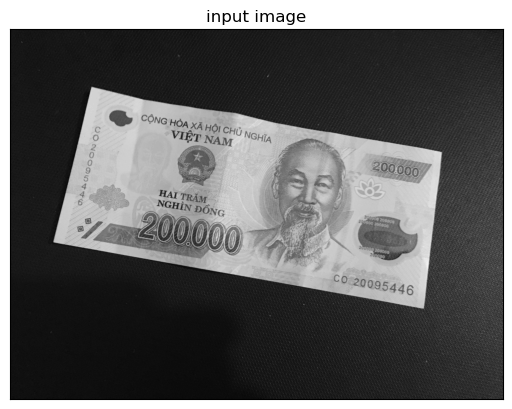

In [161]:
img = cv2.imread("VND Image\\200(4).jpg", 0)
plt.subplot(1,1,1),plt.imshow(img,'gray')
plt.title("input image")
plt.xticks([]),plt.yticks([])
plt.show()
#cv2.imwrite("template\\out.png",img )

Bước 3: Thực hiện tìm hình ảnh tờ tiền trong hình ảnh đầu vào, lấy tra hình ảnh tờ tiền

1) Làm mờ hình ảnh đầu vào với bộ lọc trung bình

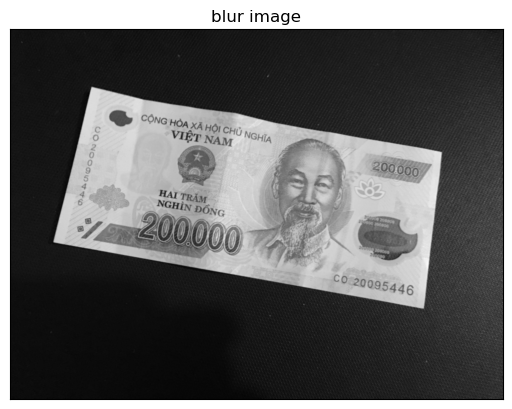

In [162]:
img_blur = cv2.blur(img, (5,5))
plt.subplot(1,1 , 1),plt.imshow(img_blur,'gray')
plt.title("blur image")
plt.xticks([]),plt.yticks([])
plt.show()

2) Tìm cạnh (canny)

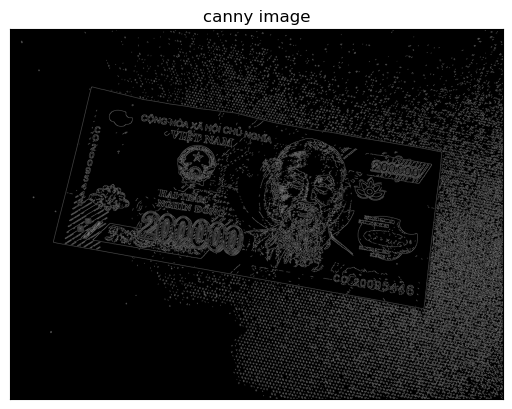

In [163]:
img_canny = cv2.Canny(img_blur,30, 40)
plt.subplot(1,1 , 1),plt.imshow(img_canny,'gray')
plt.title("canny image")
plt.xticks([]),plt.yticks([])
plt.show()
# cv2.imwrite("out.png",img_canny )

3) Close hình ảnh với kernel (30,30)

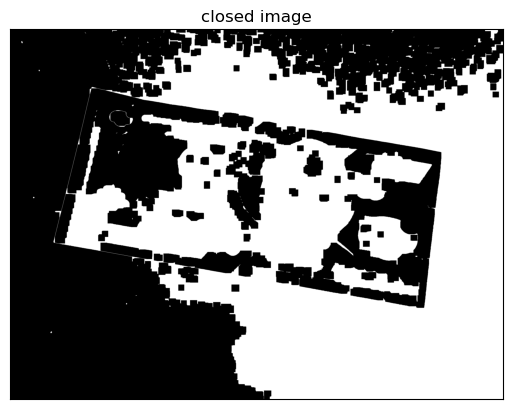

In [164]:
kernel = np.ones((30,30),np.uint8)
img_closed = cv2.morphologyEx(img_canny, cv2.MORPH_CLOSE, kernel)
plt.subplot(1,1 , 1),plt.imshow(img_closed,'gray')
plt.title("closed image")
plt.xticks([]),plt.yticks([])
plt.show()
#cv2.imwrite("out.png",img_closed )

4) Tìm contours có kích thước lớn nhất là đồng tiền

In [165]:
contours, _ = cv2.findContours(img_closed,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnt = None
s_max_large = 0
for item in contours:
    s = cv2.contourArea(item)
    if(s > s_max_large):
        s_max_large = s
        cnt = item

5) Tìm hình chữ nhật nhỏ nhất bound lấy đồng tiền

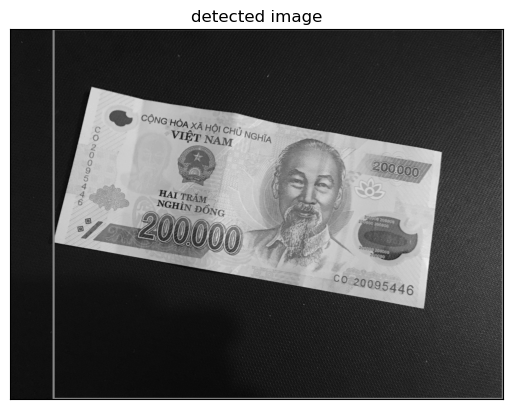

In [166]:
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
imgcp = img.copy()
im = cv2.drawContours(imgcp,[box],0,(127),10)
plt.subplot(1,1 , 1),plt.imshow(im,'gray')
plt.title("detected image")
plt.xticks([]),plt.yticks([])
plt.show()
#cv2.imwrite("out.png",imgcp )

6) Thực hiện tìm góc lệch và xoay ảnh lại cho đồng tiền nằm ngang

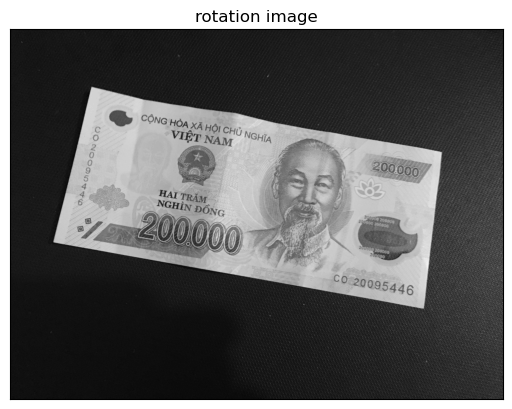

In [167]:
#xác định tâm xoay
M = cv2.moments(cnt)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
box = cv2.boxPoints(rect)
box = np.int0(box)
#xoay ảnh
angle = rect[2]
RM = cv2.getRotationMatrix2D((cx,cy),angle,1)
# tính độ dài chiều dọc (dist1) và chiều ngang(dist2). 
# nếu chiều dọc > chiều ngang đồng tiền nằm dọc khi đó cần trừ đi 90 độ xoay
dist1 = int(math.sqrt((box[1][0]  - box[0][0])**2 + (box[1][1]  - box[0][1])**2))
dist2 = int(math.sqrt((box[3][0]  - box[0][0])**2 + (box[3][1]  - box[0][1])**2))
if(dist1 > dist2):
    angle -= 90
rows, cols = img.shape
# thực hiện xoay lại ảnh
RM = cv2.getRotationMatrix2D((cx,cy),angle,1)
img_rotated = cv2.warpAffine(img,RM,(cols,rows))
plt.subplot(1,1 , 1),plt.imshow(img_rotated,'gray')
plt.title("rotation image")
plt.xticks([]),plt.yticks([])
plt.show()

Thực hiện lại từ bươc 1 -> bước 5 để tim đồng tiền với bức ảnh đồng tiền nằm ngang

In [168]:
img_blur2 = cv2.blur(img_rotated, (5,5))
img_canny2 = cv2.Canny(img_blur2,30, 40)
kernel2 = np.ones((30,30),np.uint8)
img_closed2 = cv2.morphologyEx(img_canny2, cv2.MORPH_CLOSE, kernel2)
contours2, _ = cv2.findContours(img_closed2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnt2 = None
s_max_large2 = 0
for item in contours2:
    s = cv2.contourArea(item)
    if(s > s_max_large2):
        s_max_large2 = s
        cnt2 = item

7) Tìm hình chữ nhật bound contours lớn nhất và cắt hình ảnh với hình chữ nhật này

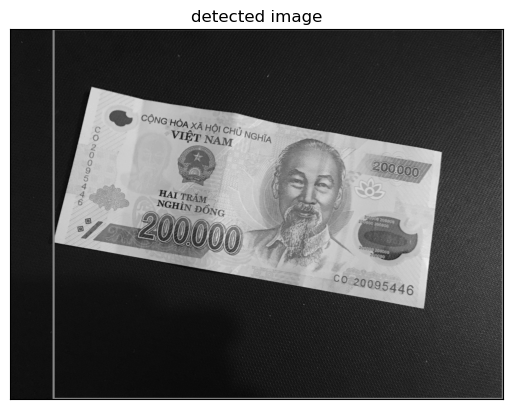

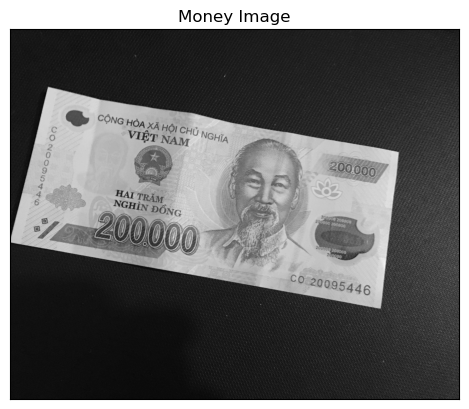

In [169]:
x,y,w,h = cv2.boundingRect(cnt2)
imcp=img_rotated.copy()
im = cv2.drawContours(imgcp,[box],0,(127),10)
plt.subplot(1,1 , 1),plt.imshow(im,'gray')
plt.title("detected image")
plt.xticks([]),plt.yticks([])
plt.show()
img_money = img_rotated[y:y+h, x:x+w]
plt.subplot(1,1 , 1),plt.imshow(img_money,'gray')
plt.title("Money Image")
plt.xticks([]),plt.yticks([])
plt.show()
#cv2.imwrite("template\\img_money.png",img_money )

Bước 4: Thực hiện so khớp (bằng phép trừ ảnh) với từng ảnh mẫu. Nếu ảnh nào khớp nhất thì đồng tiền hiện tại có giá trị cùng với ảnh mẫu đó

In [170]:
val = ""
# đặt 1 giá trị đếm pixel vô cùng lớn(lớn hơn diện tích của hình ảnh đồng tiền)
min_count = 500*500 
# thực hiện làm mờ ảnh kiểm tra
img_det_blur = cv2.blur(img_money, (5,5))
for i , im in enumerate(money_template):
    # thực hiện resize kích thước ảnh kiểm tra về cùng với ảnh mẫu để có thể trừ
    h,w = im.shape # lấy kích thước của ảnh mẫu
    im_rz = cv2.resize(img_det_blur, (w,h))
    # làm mờ ảnh mẫu
    img_ref_blur = cv2.blur(im, (5,5))
    # cân bằng sáng (Histogram Equalization) ảnh mẫu và ảnh kiểm tra để tránh ánh sáng quá sáng hoặc quá tối
    eq_ref = cv2.equalizeHist(img_ref_blur)
    eq_def = cv2.equalizeHist(im_rz)
    # thực hiện trừ ảnh
    sub_img = cv2.subtract(eq_ref, eq_def)
    # phân ngưỡng và thực hiện đếm điểm không khớp (điểm sáng là điểm không khớp)
    _, img_threshold = cv2.threshold(sub_img, 0, 255, cv2.THRESH_OTSU)
    count = cv2.countNonZero(img_threshold)
    # giá trị này càng nhỏ thì độ khớp càng lớn
    if(count  < min_count):
        min_count = count
        val = money_value[i]


Bước 5: Đồng tiền có thể nằm ngược nên xoay 180 độ và thực hiện so khớp lại 1 lần. nếu giá trị khớp nào tốt hơn thì lấy

In [171]:
# xoay ảnh 180 độ
rows, cols = img_det_blur.shape
M = cv2.getRotationMatrix2D((int(cols/2),int(rows/2)),180,1)
img_det_blur = cv2.warpAffine(img_det_blur,M,(cols,rows))
 #thực hiện so khớp lại lần 2
for i , im in enumerate(money_template):
    h,w = im.shape
    im_rz = cv2.resize(img_det_blur, (w,h))
    img_ref_blur = cv2.blur(im, (5,5))
    eq_ref = cv2.equalizeHist(img_ref_blur)
    eq_def = cv2.equalizeHist(im_rz)
    sub_img = cv2.subtract(eq_ref, eq_def)
    _, img_threshold = cv2.threshold(sub_img, 0, 255, cv2.THRESH_OTSU)
    count = cv2.countNonZero(img_threshold)
    if(count  < min_count):
        min_count = count
        val = money_value[i]
    #cv2.imwrite("out_jupyter2//" + "lan2 - " + money_value[i] + ".png", sub_img)

In giá trị đồng tiền được lưu trong biến val khi quá trình kết thúc

In [172]:
print(val)

200000     
